# Identifying Walmart Deserts in USA

This project identifies areas within USA that do not have a Walmart within the zipcode. It also studies the correlation between the Poverty Rate and the number of Walmart stores per zipcode.

## Extract Data: From csv file into a Pandas DataFrame

In [1]:
# Dependencies
import pandas as pd

# Read the Walmart Store Locations from the CSV file (from DataWorld)
input_file_path = "walmartstorelocation.csv"
walmart_locations_df = pd.read_csv(input_file_path)

walmart_locations_df
# Output: 4654 rows × 22 columns

,name,url,street_address,city,state,zip_code,country,phone_number_1,phone_number_2,fax_1,...,email_2,website,open_hours,latitude,longitude,facebook,twitter,instagram,pinterest,youtube
0,Conway Supercenter,https://www.walmart.com/store/5/conway-ar/details,1155 Hwy 65 North,Conway,AR,72032,US,501-329-0023,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",35.108660,-92.436905,NaN,NaN,NaN,NaN,NaN
1,Sikeston Supercenter,https://www.walmart.com/store/9/sikeston-mo/de...,1303 S Main St,Sikeston,MO,63801,US,573-472-3020,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.857394,-89.586051,NaN,NaN,NaN,NaN,NaN
2,Tahlequah Supercenter,https://www.walmart.com/store/10/tahlequah-ok/...,2020 S Muskogee Ave,Tahlequah,OK,74464,US,918-456-8804,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",35.888765,-94.979859,NaN,NaN,NaN,NaN,NaN
3,Mountain Home Supercenter,https://www.walmart.com/store/11/mountain-home...,65 Wal Mart Dr,Mountain Home,AR,72653,US,870-492-9299,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.354957,-92.341026,NaN,NaN,NaN,NaN,NaN
4,Claremore Supercenter,https://www.walmart.com/store/12/claremore-ok/...,1500 S Lynn Riggs Blvd,Claremore,OK,74017,US,918-341-2765,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.293955,-95.627125,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,Pearland Neighborhood Market,https://www.walmart.com/store/7361/pearland-tx...,12631 Broadway Street,Pearland,TX,77584,US,713-570-7925,NaN,NaN,...,NaN,NaN,"monday - friday : 06:00-23:00, saturday : 06:0...",29.556350,-95.415782,NaN,NaN,NaN,NaN,NaN
4650,Bentonville Gas Station,https://www.walmart.com/store/7368/bentonville...,1300 S Walton Blvd,Bentonville,AR,72712,US,479-271-2209,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",36.357486,-94.214669,NaN,NaN,NaN,NaN,NaN
4651,Millcreek Pickup only,https://www.walmart.com/store/8855/millcreek-u...,3701 S Highland Dr,Millcreek,UT,84106,US,801-467-2882,NaN,NaN,...,NaN,NaN,"monday - friday : 08:00-20:00, saturday : 08:0...",40.691031,-111.846529,NaN,NaN,NaN,NaN,NaN
4652,Dallas Supercenter,https://www.walmart.com/store/8930/dallas-tx/d...,15757 Coit Rd,Dallas,TX,75248,US,972-235-0681,NaN,NaN,...,NaN,NaN,"monday - friday : 00:00-24:00, saturday : 00:0...",32.963412,-96.770294,NaN,NaN,NaN,NaN,NaN


In [2]:
# Filtering on columns of interest
walmart_locations_clean_df = walmart_locations_df.filter(["name", "latitude", "latitude","city", "state","zip_code"])
walmart_locations_clean_df 

,name,latitude,latitude,city,state,zip_code
0,Conway Supercenter,35.108660,35.108660,Conway,AR,72032
1,Sikeston Supercenter,36.857394,36.857394,Sikeston,MO,63801
2,Tahlequah Supercenter,35.888765,35.888765,Tahlequah,OK,74464
3,Mountain Home Supercenter,36.354957,36.354957,Mountain Home,AR,72653
4,Claremore Supercenter,36.293955,36.293955,Claremore,OK,74017
...,...,...,...,...,...,...
4649,Pearland Neighborhood Market,29.556350,29.556350,Pearland,TX,77584
4650,Bentonville Gas Station,36.357486,36.357486,Bentonville,AR,72712
4651,Millcreek Pickup only,40.691031,40.691031,Millcreek,UT,84106
4652,Dallas Supercenter,32.963412,32.963412,Dallas,TX,75248


In [3]:
# Drop na values
walmart_locations_clean_df.dropna(how='any')
walmart_locations_clean_df 

,name,latitude,latitude,city,state,zip_code
0,Conway Supercenter,35.108660,35.108660,Conway,AR,72032
1,Sikeston Supercenter,36.857394,36.857394,Sikeston,MO,63801
2,Tahlequah Supercenter,35.888765,35.888765,Tahlequah,OK,74464
3,Mountain Home Supercenter,36.354957,36.354957,Mountain Home,AR,72653
4,Claremore Supercenter,36.293955,36.293955,Claremore,OK,74017
...,...,...,...,...,...,...
4649,Pearland Neighborhood Market,29.556350,29.556350,Pearland,TX,77584
4650,Bentonville Gas Station,36.357486,36.357486,Bentonville,AR,72712
4651,Millcreek Pickup only,40.691031,40.691031,Millcreek,UT,84106
4652,Dallas Supercenter,32.963412,32.963412,Dallas,TX,75248


In [4]:
# Check the datatype of the Zipcode column
walmart_locations_df.dtypes

name               object
url                object
street_address     object
city               object
state              object
zip_code            int64
country            object
phone_number_1     object
phone_number_2    float64
fax_1             float64
fax_2             float64
email_1           float64
email_2           float64
website           float64
open_hours         object
latitude          float64
longitude         float64
facebook          float64
twitter           float64
instagram         float64
pinterest         float64
youtube           float64
dtype: object

## Extract Data: From US zipcde data from csv file into a Pandas DataFrame

In [5]:
# Read the US zipcode lat long info from the CSV file (from OpenDataSoft.com)
zip_file_path = "us-zip-code-latitude-and-longitude.csv"
us_zipcode_latlng_df = pd.read_csv(zip_file_path, delimiter =";")

us_zipcode_latlng_df

# Output:  43191 rows × 8 columns

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.393980,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.160560,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.743570,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.897540,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.980270,-6,1,"41.194129,-91.98027"
...,...,...,...,...,...,...,...,...
43186,15207,Pittsburgh,PA,40.399355,-79.934140,-5,1,"40.399355,-79.93414"
43187,52647,Olds,IA,41.133346,-91.545590,-6,1,"41.133346,-91.54559"
43188,16683,Spruce Creek,PA,40.662087,-78.070120,-5,1,"40.662087,-78.07012"
43189,55459,Minneapolis,MN,45.015914,-93.471880,-6,1,"45.015914,-93.47188"


In [6]:
us_zipcode_latlng_df = us_zipcode_latlng_df.dropna(how='any')
us_zipcode_latlng_df

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.393980,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.160560,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.743570,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.897540,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.980270,-6,1,"41.194129,-91.98027"
...,...,...,...,...,...,...,...,...
43186,15207,Pittsburgh,PA,40.399355,-79.934140,-5,1,"40.399355,-79.93414"
43187,52647,Olds,IA,41.133346,-91.545590,-6,1,"41.133346,-91.54559"
43188,16683,Spruce Creek,PA,40.662087,-78.070120,-5,1,"40.662087,-78.07012"
43189,55459,Minneapolis,MN,45.015914,-93.471880,-6,1,"45.015914,-93.47188"


In [7]:
# Renaming columns of interest - lat, long, zipcode
us_zipcode_df = us_zipcode_latlng_df.rename(columns=({"Zip":"zipcode", 
                                                            "Latitude": "latitude",
                                                            "Longitude": "longitude"}))
us_zipcode_df

,zipcode,City,State,latitude,longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.393980,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.160560,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.743570,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.897540,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.980270,-6,1,"41.194129,-91.98027"
...,...,...,...,...,...,...,...,...
43186,15207,Pittsburgh,PA,40.399355,-79.934140,-5,1,"40.399355,-79.93414"
43187,52647,Olds,IA,41.133346,-91.545590,-6,1,"41.133346,-91.54559"
43188,16683,Spruce Creek,PA,40.662087,-78.070120,-5,1,"40.662087,-78.07012"
43189,55459,Minneapolis,MN,45.015914,-93.471880,-6,1,"45.015914,-93.47188"


In [8]:
us_zipcode_latlng_df = us_zipcode_df.filter(['zipcode', 'latitude','longitude'])
us_zipcode_latlng_df

,zipcode,latitude,longitude
0,71937,34.398483,-94.393980
1,72044,35.624351,-92.160560
2,56171,43.660847,-94.743570
3,49430,43.010337,-85.897540
4,52585,41.194129,-91.980270
...,...,...,...
43186,15207,40.399355,-79.934140
43187,52647,41.133346,-91.545590
43188,16683,40.662087,-78.070120
43189,55459,45.015914,-93.471880


In [9]:
us_zipcode_latlng_df = us_zipcode_latlng_df.dropna(how='any')
us_zipcode_latlng_df

,zipcode,latitude,longitude
0,71937,34.398483,-94.393980
1,72044,35.624351,-92.160560
2,56171,43.660847,-94.743570
3,49430,43.010337,-85.897540
4,52585,41.194129,-91.980270
...,...,...,...
43186,15207,40.399355,-79.934140
43187,52647,41.133346,-91.545590
43188,16683,40.662087,-78.070120
43189,55459,45.015914,-93.471880


In [10]:
# Check dtypes
us_zipcode_latlng_df.dtypes

zipcode        int64
latitude     float64
longitude    float64
dtype: object

## Transform store data to get the store counts per zipcode

In [11]:
# Select required columns in a new dataframe
stores_df = walmart_locations_df[["name", "zip_code"]]
stores_df
# Output: 4654 rows × 2 columns

,name,zip_code
0,Conway Supercenter,72032
1,Sikeston Supercenter,63801
2,Tahlequah Supercenter,74464
3,Mountain Home Supercenter,72653
4,Claremore Supercenter,74017
...,...,...
4649,Pearland Neighborhood Market,77584
4650,Bentonville Gas Station,72712
4651,Millcreek Pickup only,84106
4652,Dallas Supercenter,75248


In [12]:
# Group by zipcode to find the count of stores per zipcode and store this grouped data in a new dataframe
store_count_df = stores_df.groupby(["zip_code"]).count()
store_count_df
# Output: 4177 rows × 1 columns

,name
zip_code,
617,1
659,1
662,1
674,1
680,1
...,...
99611,1
99615,1
99654,1


In [13]:
# Rename the Name column to "Store Count" column 
store_count_df = store_count_df.rename(columns={'name': "count"})
store_count_df

,count
zip_code,
617,1
659,1
662,1
674,1
680,1
...,...
99611,1
99615,1
99654,1


In [14]:
# Reset the Index and store in a new dataframe
store_count_clean_df = store_count_df.reset_index()
store_count_clean_df

,zip_code,count
0,617,1
1,659,1
2,662,1
3,674,1
4,680,1
...,...,...
4172,99611,1
4173,99615,1
4174,99654,1
4175,99701,1


In [15]:
# Rename columns to match database schema
store_count_clean_df = store_count_clean_df.rename(columns={'zip_code': "zipcode",
                                                           'count': "store_count"})
store_count_clean_df

,zipcode,store_count
0,617,1
1,659,1
2,662,1
3,674,1
4,680,1
...,...,...
4172,99611,1
4173,99615,1
4174,99654,1
4175,99701,1


## Run Census Search to retrieve data on all zip codes (2018 ACS5 Census)

In [16]:
# Census Dependencies
# Census API Key
from config import (census_key, gkey)
from census import Census
c = Census(census_key, year=2018)

census_data = c.acs5.get(("B01003_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df = census_df.rename(columns={"B01003_001E": "population",
                                      "B17001_002E": "poverty_count",
                                      "zip code tabulation area": "zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_df["poverty_rate"] = (census_df["poverty_count"]/census_df["population"])*100
row_count = len(census_df)

print(f"Total number of records: {row_count}")
census_df

# Output: 33120 rows × 4 columns

Total number of records: 33120


,population,poverty_count,zipcode,poverty_rate
0,17242.0,10772.0,00601,62.475351
1,38442.0,19611.0,00602,51.014515
2,48814.0,24337.0,00603,49.856599
3,6437.0,4163.0,00606,64.672984
4,27073.0,11724.0,00610,43.305138
...,...,...,...,...
33115,15.0,0.0,99923,0.000000
33116,927.0,172.0,99925,18.554477
33117,1635.0,235.0,99926,14.373089
33118,38.0,28.0,99927,73.684211


In [17]:
census_df.dtypes

population       float64
poverty_count    float64
zipcode           object
poverty_rate     float64
dtype: object

In [18]:
census_df["zipcode"] = census_df["zipcode"].astype(int)
census_df.dtypes

population       float64
poverty_count    float64
zipcode            int32
poverty_rate     float64
dtype: object

## Transform Data: Merge the store counts with poverty data per zipcode

In [19]:
# Merge the two data sets along zip code
stores_per_zip_df = pd.merge(store_count_clean_df, census_df, how="left", on=["zipcode"])

# Remove rows missing data
stores_per_zip_clean_df = stores_per_zip_df.dropna()

# Visualize
stores_per_zip_clean_df

#Output: 4168 rows × 5 columns

,zipcode,store_count,population,poverty_count,poverty_rate
0,617,1,23974.0,11879.0,49.549512
1,659,1,40390.0,18717.0,46.340678
2,662,1,40290.0,21809.0,54.130057
3,674,1,39859.0,18226.0,45.726185
4,680,1,46395.0,23841.0,51.387003
...,...,...,...,...,...
4172,99611,1,15657.0,2041.0,13.035703
4173,99615,1,12971.0,1100.0,8.480456
4174,99654,1,62135.0,6236.0,10.036211
4175,99701,1,17510.0,2359.0,13.472302


In [20]:
stores_per_zip_clean_df.dtypes

zipcode            int64
store_count        int64
population       float64
poverty_count    float64
poverty_rate     float64
dtype: object

In [21]:
# Merge the two data sets along zip code to get the Lat Long
merged_df = pd.merge(stores_per_zip_clean_df, us_zipcode_latlng_df, how="left", on=["zipcode"])

merged_df


,zipcode,store_count,population,poverty_count,poverty_rate,latitude,longitude
0,617,1,23974.0,11879.0,49.549512,18.455499,-66.55575
1,659,1,40390.0,18717.0,46.340678,18.432956,-66.80039
2,662,1,40290.0,21809.0,54.130057,18.478855,-67.01973
3,674,1,39859.0,18226.0,45.726185,18.426137,-66.48697
4,680,1,46395.0,23841.0,51.387003,18.205232,-67.12655
...,...,...,...,...,...,...,...
4163,99611,1,15657.0,2041.0,13.035703,60.587598,-151.23355
4164,99615,1,12971.0,1100.0,8.480456,57.746630,-152.51142
4165,99654,1,62135.0,6236.0,10.036211,61.580187,-149.48821
4166,99701,1,17510.0,2359.0,13.472302,64.835070,-147.72045


In [22]:
merged_df = merged_df.dropna(how='any')
merged_df

,zipcode,store_count,population,poverty_count,poverty_rate,latitude,longitude
0,617,1,23974.0,11879.0,49.549512,18.455499,-66.55575
1,659,1,40390.0,18717.0,46.340678,18.432956,-66.80039
2,662,1,40290.0,21809.0,54.130057,18.478855,-67.01973
3,674,1,39859.0,18226.0,45.726185,18.426137,-66.48697
4,680,1,46395.0,23841.0,51.387003,18.205232,-67.12655
...,...,...,...,...,...,...,...
4163,99611,1,15657.0,2041.0,13.035703,60.587598,-151.23355
4164,99615,1,12971.0,1100.0,8.480456,57.746630,-152.51142
4165,99654,1,62135.0,6236.0,10.036211,61.580187,-149.48821
4166,99701,1,17510.0,2359.0,13.472302,64.835070,-147.72045


In [23]:
merged_df.dtypes

zipcode            int64
store_count        int64
population       float64
poverty_count    float64
poverty_rate     float64
latitude         float64
longitude        float64
dtype: object

## Load Data into the PostgreSQL Database

In [24]:
# Dependencies
from sqlalchemy import create_engine
from config import (postgres_id, postgres_pw)

In [25]:
# Connect to a local database
conn_str = f"{postgres_id}:{postgres_pw}@localhost:5432/etl_project_db"
engine = create_engine(f'postgresql://{conn_str}')

In [26]:
# check tables in the database
engine.table_names()

['store_counts', 'walmart_stores', 'final_df']

In [31]:
# Load the DataFrames into the database
store_count_clean_df.to_sql(name='store_counts',  if_exists='append', con=engine,index=False)

In [32]:
# Confirm that the data loaded correctly
pd.read_sql_query('select * from store_counts', con=engine)

,zipcode,store_count
0,617,1
1,659,1
2,662,1
3,674,1
4,680,1
...,...,...
4172,99611,1
4173,99615,1
4174,99654,1
4175,99701,1


In [33]:
# Load the merged DataFrames into the database
stores_per_zip_clean_df.to_sql(name='walmart_stores', con=engine, if_exists='append', index=False)

In [34]:
# Confirm that the data loaded correctly
pd.read_sql_query('select * from walmart_stores', con=engine)

,zipcode,store_count,population,poverty_count,poverty_rate
0,617,1,23974.0,11879.0,49.549512
1,659,1,40390.0,18717.0,46.340678
2,662,1,40290.0,21809.0,54.130057
3,674,1,39859.0,18226.0,45.726185
4,680,1,46395.0,23841.0,51.387003
...,...,...,...,...,...
4163,99611,1,15657.0,2041.0,13.035703
4164,99615,1,12971.0,1100.0,8.480456
4165,99654,1,62135.0,6236.0,10.036211
4166,99701,1,17510.0,2359.0,13.472302


In [35]:
# Load the final DataFrame into the database
merged_df.to_sql(name='final_df', con=engine, if_exists='append', index=False)

In [36]:
# Confirm that the data loaded correctly
pd.read_sql_query('select * from final_df', con=engine)

,zipcode,store_count,population,poverty_count,poverty_rate,latitude,longitude
0,617,1,23974.0,11879.0,49.549512,18.455499,-66.55575
1,659,1,40390.0,18717.0,46.340678,18.432956,-66.80039
2,662,1,40290.0,21809.0,54.130057,18.478855,-67.01973
3,674,1,39859.0,18226.0,45.726185,18.426137,-66.48697
4,680,1,46395.0,23841.0,51.387003,18.205232,-67.12655
...,...,...,...,...,...,...,...
4118,99611,1,15657.0,2041.0,13.035703,60.587598,-151.23355
4119,99615,1,12971.0,1100.0,8.480456,57.746630,-152.51142
4120,99654,1,62135.0,6236.0,10.036211,61.580187,-149.48821
4121,99701,1,17510.0,2359.0,13.472302,64.835070,-147.72045


## Visualization

### Build a base map for the visualization

In [37]:
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt


In [38]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [39]:
# Store the Walmart store location (Latitude and 'Longitude) into  a series "locations" for plotting
locations = merged_df[["latitude", "longitude"]].astype(float)

In [40]:
locations

,latitude,longitude
0,18.455499,-66.55575
1,18.432956,-66.80039
2,18.478855,-67.01973
3,18.426137,-66.48697
4,18.205232,-67.12655
...,...,...
4163,60.587598,-151.23355
4164,57.746630,-152.51142
4165,61.580187,-149.48821
4166,64.835070,-147.72045


In [41]:
# Create a base map
fig = gmaps.figure()
fig

Figure(layout=FigureLayout(height='420px'))

### Add a Symbol layer for store counts

In [42]:
# Convert store count to a list
store_count = merged_df["store_count"].tolist()

In [44]:
# Add the Store symbol layer
store_layer = gmaps.symbol_layer(locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"Store Count: {store}" for store in store_count]
)


fig = gmaps.figure()
fig.add_layer(store_layer)

fig


Figure(layout=FigureLayout(height='420px'))

### Add a Heatmap layer with  poverty rate

In [45]:
#Create a list of poverty rate as a float
poverty_rate = merged_df["poverty_rate"].tolist()
poverty_rate


[49.549511971302245,
 46.34067838573904,
 54.130057086125596,
 45.72618480142502,
 51.38700290979631,
 41.22649121718081,
 46.35246108116278,
 42.569728451534125,
 43.78941595832191,
 43.00105346326047,
 47.09507840116016,
 38.86552819016562,
 49.06476588423252,
 44.015730198274625,
 26.459696333785953,
 33.73347227673194,
 30.765982328482327,
 26.253475804900226,
 10.622321161577567,
 5.630885122410547,
 14.449584891311238,
 14.632533534857359,
 6.690191216441753,
 19.873770732423306,
 13.865536799157082,
 15.160855326526681,
 10.31470777135517,
 14.089029433227926,
 13.19175545347411,
 6.5655221364563925,
 7.867284844972472,
 2.1221221221221223,
 7.033639143730887,
 5.1263794944820225,
 4.9504950495049505,
 5.565217391304348,
 14.155889549108702,
 4.000614062020264,
 5.7932353533319905,
 3.3827778848006163,
 9.190507607109298,
 2.8896560542130163,
 17.80875711761241,
 9.44079531333215,
 5.521360673052409,
 14.475727030471555,
 3.408556652562295,
 3.576220456187429,
 11.77894811254064

In [46]:
# Add a heat layer with poverty_rate
poverty_heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, dissipating=False, max_intensity=100, point_radius = 1)

fig = gmaps.figure()
fig.add_layer(poverty_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### Combine all maps

In [49]:
fig = gmaps.figure()
fig.add_layer(store_layer)
fig.add_layer(poverty_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [51]:
plt.savefig('CombinedVisualization.png')

<Figure size 432x288 with 0 Axes>

### Statistical Analysis

#### Linear Regression to see relationship between Poverty Rate and Walmart store counts

Correlation Coefficient: -0.030213719601892695


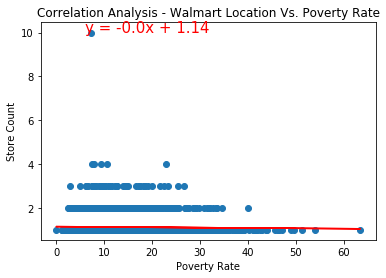

In [55]:
## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = merged_df['poverty_rate'].astype('float')
y_values = merged_df['store_count'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate')
plt.ylabel('Store Count')
plt.title('Correlation Analysis - Walmart Location Vs. Poverty Rate')

print(f"Correlation Coefficient: {rvalue}")
plt.savefig('LinearRegression.png')

# Show plot
plt.show()

## Conclusion
       1. There is no correlation between poverty rates and the number of Walmart stores in the US.